In [65]:
# !pip install -q -U tensorflow_hub

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from keras.callbacks import EarlyStopping


In [16]:
%config InlineBackend.figure_format='retina'

#### select selected columns from the pandas dataframe


In [17]:
df = pd.read_csv('wine-reviews.csv', usecols=['country', 'description',  'points', 'price', 'variety', 'winery' ])

In [18]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",87,65.0,Pinot Noir,Sweet Cheeks


#### dropna values from the description and the points columns

In [19]:
df.dropna(subset=['description', 'points'], inplace=True)

<h2> This is the summary for the final df </h2>

In [20]:
df.isna().sum()

country          63
description       0
points            0
price          8996
variety           1
winery            0
dtype: int64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      129908 non-null  object 
 1   description  129971 non-null  object 
 2   points       129971 non-null  int64  
 3   price        120975 non-null  float64
 4   variety      129970 non-null  object 
 5   winery       129971 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.9+ MB


### EDA

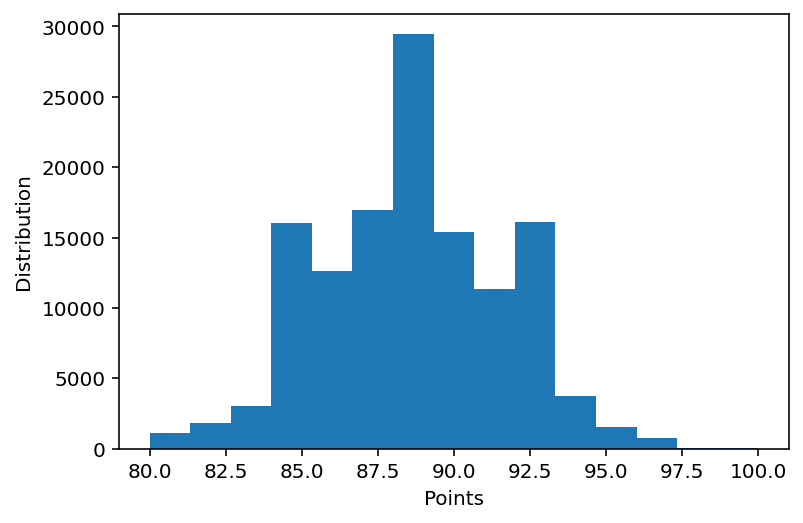

In [22]:
plt.hist(df.points, bins=15)
plt.xlabel('Points')
plt.ylabel('Distribution')
plt.show()

#### Apply lambda function tp perticular column

In [23]:
df['label'] = df.points.apply(lambda x: 1 if x >= 90 else 0)

In [24]:
df.label.value_counts()

0    80926
1    49045
Name: label, dtype: int64

In [25]:
# we can also use the following code to create a new column called 'label' instead of using the apply function
# df['label'] = (df['points'] >= 90).astype(int)

In [26]:
df = df[['description', 'label']]

In [27]:
train, val, test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))])

In [28]:
print(train.shape, val.shape, test.shape)

(103976, 2) (12997, 2) (12998, 2)


### What is the puropose of the following code?
### look it into details later.

In [30]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [31]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [58]:
for i in train_data.take(1):
  print(i)

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
array([b'A very rich, dramatic, indisputably Napa Cabernet. The fruit is ripe in blackberries and cassis, the tannin structure is vibrant and living, and the oak application is superb. A fashionable Cab that should develop over the next eight years.',
       b'This is a pleasant red wine from Piedmont in northern Italy made with Nebbiolo and Vespolina grapes for a clean delivery of berry, spice and cola aromas. The wine is tonic and fresh in the mouth with clean acidity and playful bite of exotic spice on the close.',
       b'This is a broad, sweet, full-bodied dessert wine that lacks the crisp acids necessary for a higher degree of balance. Instead, it delivers intense honey and pineapple flavors that stick stubbornly to the palate. Probably best with sweet desserts.',
       ...,
       b'Touched by spice from wood aging, this is a balanced wine. Its toastiness supports the ripe peach and apricot fruits, lifted by acidity. It will be 

In [67]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

2022-06-21 00:10:43.039473: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [80]:
list(train_data)[0][0]

<tf.Tensor: shape=(1024,), dtype=string, numpy=
array([b'Completely stainless-fermented and aged, this is a blockbuster of a white wine, refreshing and exotic in floral intoxication. Dry and light-bodied, it offers an edginess of slate-like minerality along with aromas of apricot and peach, finishing in a dusting of white pepper.',
       b'The label says Napa Valley but the grapes come from Carneros, and you can taste the cool fog in the crisp acidity that frames long hangtime flavors of ripe pineapple, guava, nectarine, roasted peach and lime custard. This is a pretty Chard, balanced and dry, and it impresses for its volume and length.',
       b'Ripe white grapefruit and lychee notes perfume this refreshing, easy-drinking Gr\xc3\xbcner Veltliner. On the palate, gooseberry and lime flavors are delicate in concentration but it finishes with an invigorating brace of crushed minerals.',
       ...,
       b'This blend of Sangiovese and Merlot starts with aromas of espresso, toasted oak 

In [82]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[-0.0012439 , -0.09365706, -0.12321281, ..., -0.3201542 ,
        -0.1284347 ,  0.05955575],
       [ 0.33945358, -0.23618123, -0.2305099 , ..., -0.08266268,
         0.27211103,  0.15572451],
       [ 0.28139442, -0.12988901,  0.09559803, ...,  0.18410209,
        -0.05989112, -0.11929152],
       ...,
       [ 0.45168313, -0.13605252, -0.31841782, ..., -0.10140887,
        -0.1788628 ,  0.2342917 ],
       [ 0.45715016, -0.16173916, -0.12438109, ...,  0.10529581,
        -0.17982656,  0.04192869],
       [ 0.08921701, -0.22221851, -0.2257588 , ...,  0.0052031 ,
         0.11706206, -0.09028736]], dtype=float32)>

### Define a deep neural net model.

In [112]:
def get_model():
    model = tf.keras.Sequential()
    model.add(hub_layer)
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
    return model

In [113]:
model = get_model()

#### This is model evaluation on test data and validation data without training the network and accuracy is pretty bad 38.22%

In [114]:
model.evaluate(train_data)

102/102 [==============================] - 2s 21ms/step - loss: 0.7354 - accuracy: 0.3822


[0.7354397177696228, 0.3821747303009033]

In [86]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 5ms/step - loss: 0.7118 - accuracy: 0.3856


[0.7117805480957031, 0.3856274485588074]

#### Training the model using 10 epochs.

In [117]:
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
102/102 [==============================] - 15s 150ms/step - loss: 0.2529 - accuracy: 0.8935 - val_loss: 0.4000 - val_accuracy: 0.8287
Epoch 2/10
102/102 [==============================] - 16s 152ms/step - loss: 0.2458 - accuracy: 0.8962 - val_loss: 0.4008 - val_accuracy: 0.8291
Epoch 3/10
102/102 [==============================] - 16s 154ms/step - loss: 0.2365 - accuracy: 0.9007 - val_loss: 0.4053 - val_accuracy: 0.8283
Epoch 4/10
102/102 [==============================] - 15s 150ms/step - loss: 0.2276 - accuracy: 0.9049 - val_loss: 0.4120 - val_accuracy: 0.8300
Epoch 5/10
102/102 [==============================] - 16s 152ms/step - loss: 0.2183 - accuracy: 0.9090 - val_loss: 0.4192 - val_accuracy: 0.8305
Epoch 6/10
102/102 [==============================] - 16s 160ms/step - loss: 0.2093 - accuracy: 0.9132 - val_loss: 0.4318 - val_accuracy: 0.8332
Epoch 7/10
102/102 [==============================] - 16s 155ms/step - loss: 0.2000 - accuracy: 0.9174 - val_loss: 0.4394 - val_ac

In [123]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

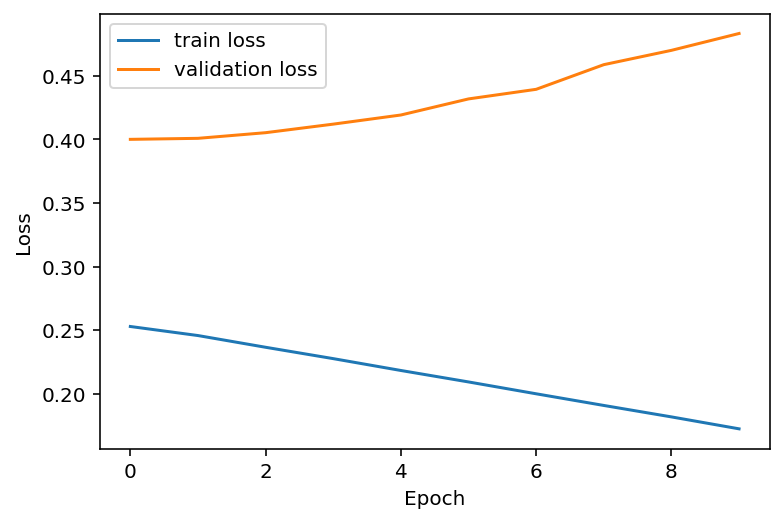

In [130]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

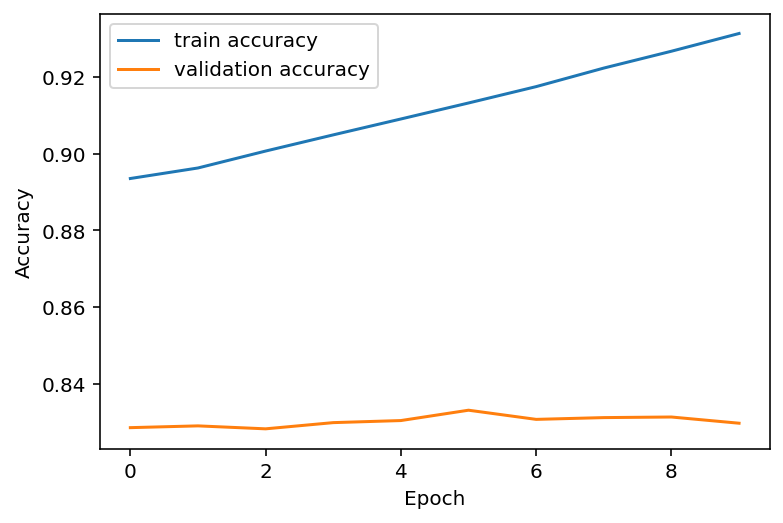

In [131]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### As we can see, the model training accuracy keep on increasing w.r.t the epochs but the validation accuracy reached a peak value and start decreasing again. And similiar pattern is observed for the loss function but in the opposite sense. This is related to the overfitting problem.
#### There are two ways we can solve this problem.
<li>Use drop layers in between the layer</li>
<li>Stop training the model before the loss value starts to increase</li>

In [134]:
def get_model1():
    model = tf.keras.Sequential()
    model.add(hub_layer)
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
    return model

In [135]:
model1 = get_model1()

### Here we are using earlystop callback to stop training when the loss on the validation data is reached the minimum value.

In [136]:
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=3)
history = model1.fit(train_data, epochs=20, validation_data=valid_data, callbacks=[es])


Epoch 1/20
102/102 [==============================] - 16s 150ms/step - loss: 0.6160 - accuracy: 0.6723 - val_loss: 0.4544 - val_accuracy: 0.8220
Epoch 2/20
102/102 [==============================] - 15s 148ms/step - loss: 0.4045 - accuracy: 0.8358 - val_loss: 0.3786 - val_accuracy: 0.8326
Epoch 3/20
102/102 [==============================] - 15s 148ms/step - loss: 0.3282 - accuracy: 0.8695 - val_loss: 0.3807 - val_accuracy: 0.8307
Epoch 4/20
102/102 [==============================] - 15s 149ms/step - loss: 0.2939 - accuracy: 0.8838 - val_loss: 0.3965 - val_accuracy: 0.8287
Epoch 5/20
102/102 [==============================] - 15s 148ms/step - loss: 0.2688 - accuracy: 0.8932 - val_loss: 0.4123 - val_accuracy: 0.8282
Epoch 5: early stopping


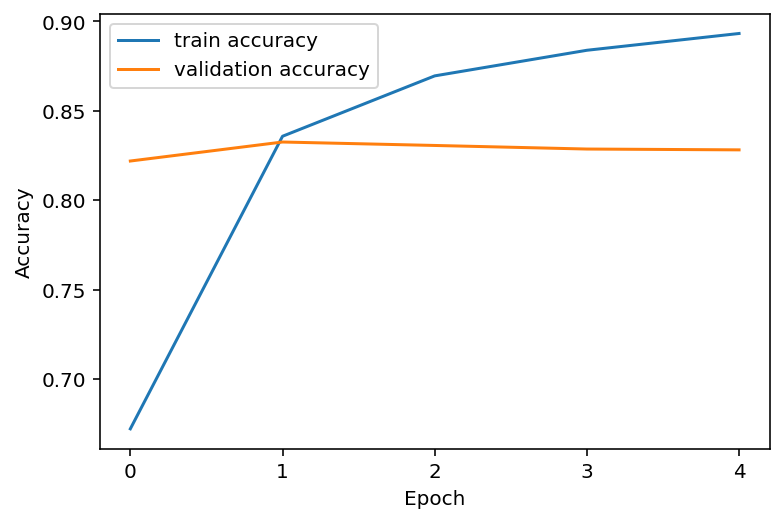

In [151]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.xticks(history.epoch)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [161]:
np.argmax(history.history['val_accuracy'])

1

#### After the earlystop callback is triggered, the model is not trained anymore and maximum accuracy is achieved at 1st epoch training.

In [137]:
model1.evaluate(test_data)

13/13 [==============================] - 0s 22ms/step - loss: 0.4250 - accuracy: 0.8215


[0.42498770356178284, 0.8215110301971436]

In [139]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 23ms/step - loss: 0.5228 - accuracy: 0.8149


[0.5227763056755066, 0.81488037109375]